In [1]:
#Bibliotecas
from pulp import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Dados de entrada

# CSV Excel
custo = np.genfromtxt("amostra_tsp.csv", delimiter = ",")

#Parametros
n = len(custo)
arcos = [(i,j) for i in range(n) for j in range(n) if custo[i,j] != 999]

#Inicializar o LP
tsp = LpProblem("CaixeiroViajante", LpMinimize)

#Variaveis de decisao
x = LpVariable.dicts("x", arcos, cat = "Binary")
u = LpVariable.dicts("u", [i for i in range(n)], lowBound = 1, 
                     upBound = n, cat = "Continuous")

#Funcao objetivo
tsp += lpSum([custo[i,j] * x[i,j] for (i,j) in arcos])

#Restricao 1
for j in range(n):
    tsp += lpSum([x[i,j] for (i,m) in arcos if m==j]) == 1
    
#Restricao 2
for i in range(n):
    tsp += lpSum([x[i,j] for (m,j) in arcos if m == i]) == 1
    
#Restricao 3 - Subtour elimination
for (i,j) in arcos:
    if i > 0 and i != j:
        tsp += u[i] - u[j] + n*x[i,j] <= n-1
        
#Resolvendo o modelo
# solver_list = listSolvers(onlyAvailable=True)
# print(solver_list)
solver = getSolver('GUROBI_CMD')
resolver_modelo = tsp.solve(solver)
print(f"Status do problema: {LpStatus[resolver_modelo]}")

#Display variaveis
for var in tsp.variables():
    if var.varValue > 0:
        print(f"{var.name} = {var.varValue}")

#Display funcao objetivo
print(f"Custo total = ${value(tsp.objective)}")

Status do problema: Optimal
u_0 = 5.0
u_1 = 2.0
u_2 = 4.0
u_3 = 1.0
u_4 = 3.0
x_(0,_3) = 1.0
x_(1,_4) = 1.0
x_(2,_0) = 1.0
x_(3,_1) = 1.0
x_(4,_2) = 1.0
Custo total = $76.0


In [16]:
#Lista com os arcos atravessados pelo caixeiro
arcos_caminho = []

for var in tsp.variables():
    if var.name[0] == "x":
        if var.varValue > 0:
            #Encontrando os indices para dividir a string
            open_parenthesis = var.name.find("(")
            close_parenthesis = var.name.find(")")
            comma = var.name.find(",")
            second_underline = var.name.find("_", comma)
            
            #Determinar (i,j)
            i = int(var.name[open_parenthesis+1: comma])
            j = int(var.name[second_underline+1: close_parenthesis])
            
            arcos_caminho.append((i,j))
            arcos_caminho.append((j,i)) #Simetrico
            
print(arcos_caminho)

[(0, 3), (3, 0), (1, 4), (4, 1), (2, 0), (0, 2), (3, 1), (1, 3), (4, 2), (2, 4)]


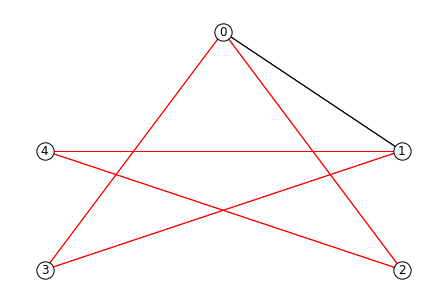

In [17]:
#Criar o grafo
G = nx.Graph()

#Adicionando todos os arcos
G.add_edges_from(arcos)

#Posicao dos nos
coordenadas = [[2,3], [3, 2], [3,1], [1,1], [1,2]]

#Identificando a cor dos arcos
cores = []
for arco in arcos:
    if arco in arcos_caminho:
        cores.append("red")
    else:
        cores.append("black")

#Plotar o grafo
nx.draw(G, pos = coordenadas, with_labels = True, node_color = "white", 
        edgecolors = "black", edgelist = arcos, edge_color = cores)
